In [1]:
################################################## Import necessary libraries ######################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# Filter warning messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Visualization settings
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# Problem Definition and Understanding

The goal of this project is to predict the loan grades for individuals in the test dataset based on the patterns learned from the training dataset. The training data contains historical information on loan grades, and we aim to develop a machine learning model that can effectively generalize from this historical data to accurately predict the loan grades for new, unseen individuals in the test set. The predictive model is trained using features such as employment length, loan purpose, and other relevant information available in the training dataset. The ultimate objective is to create a robust and accurate model that can contribute to making reliable predictions of loan grades for individuals who do not have known loan grades in the test dataset. The success of the project will be measured by the model's ability to provide accurate predictions on the test set, evaluated through metrics like accuracy, precision, recall, and F1-score.


## 0. Read the Data


In [2]:
# Read the training data from the "train.csv" file into a DataFrame called 'train'
train = pd.read_csv("train.csv")

# Read the test data from the "test.csv" file into a DataFrame called 'test'
test = pd.read_csv("test.csv")

## 1. Data Preprocessing


In [3]:
train.head(10)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
5,TRAIN_00005,4800000,36 months,10+ years,RENT,84000000,13.78,30,휴가,0,240216,55428.0,0.0,0.0,A
6,TRAIN_00006,3600000,36 months,9 years,MORTGAGE,55200000,16.12,22,휴가,0,77892,46344.0,0.0,0.0,D
7,TRAIN_00007,12000000,60 months,2 years,RENT,66000000,14.73,45,부채 통합,0,557232,566136.0,0.0,0.0,C
8,TRAIN_00008,9840000,36 months,10+ years,OWN,45600000,20.27,11,의료,0,425928,266352.0,0.0,0.0,D
9,TRAIN_00009,2880000,36 months,2 years,RENT,72000000,10.02,26,자동차,0,268848,115572.0,0.0,0.0,C


In [4]:
train.shape

(96294, 15)

In [5]:
train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [6]:
train.columns

Index(['ID', '대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [8]:
test.head(10)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,TEST_00003,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,TEST_00004,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
5,TEST_00005,30000000,36 months,Unknown,MORTGAGE,180000000,30.10,50,신용 카드,0,1544304,249288.0,0.0,0.0
6,TEST_00006,24000000,60 months,10+ years,MORTGAGE,114000000,16.13,50,부채 통합,0,311904,182196.0,0.0,0.0
7,TEST_00007,7200000,36 months,Unknown,OWN,40800000,22.87,15,신용 카드,0,0,0.0,0.0,0.0
8,TEST_00008,28800000,60 months,3 years,RENT,114000000,27.70,46,부채 통합,0,763200,407916.0,0.0,0.0
9,TEST_00009,1350000,36 months,10+ years,RENT,48000000,16.80,7,기타,0,125832,54372.0,0.0,0.0


In [9]:
test.shape

(64197, 14)

In [10]:
test.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,6.419700e+04,6.419700e+04,64197.000000,64197.000000,64197.000000,6.419700e+04,6.419700e+04,64197.000000,64197.000000
mean,1.829630e+07,9.446378e+07,19.433747,25.295310,0.342882,8.231412e+05,4.324562e+05,50.313192,0.005499
std,1.038592e+07,1.117071e+08,40.375816,12.021127,0.901277,9.880161e+05,4.472797e+05,1396.384546,0.080020
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.008000e+07,5.759880e+07,12.630000,17.000000,0.000000,3.081840e+05,1.343520e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.770000,24.000000,0.000000,5.986800e+05,2.875680e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.560000,32.000000,0.000000,1.061508e+06,5.774160e+05,0.000000,0.000000
max,4.200000e+07,1.044790e+10,9999.000000,135.000000,15.000000,4.049760e+07,5.645688e+06,108240.000000,4.000000


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          64197 non-null  object 
 4   주택소유상태        64197 non-null  object 
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  object 
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 6.9+ MB


In [12]:
# Using the select_dtypes method from the pandas library to choose columns with data types "object" and "category".
cat_col = train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_col

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급']

In [13]:
# Iterating over a subset of categorical columns (columns 1 to 2) in the DataFrame 'train'.

for col in cat_col[1:3]:
    # Calculating the counts of each category in the selected column.
    category_counts = train[col].value_counts()

    # Printing the categories and their counts for the current column.
    print(f"{col} Categories:")
    print(category_counts)
    print()

대출기간 Categories:
 36 months    64479
 60 months    31815
Name: 대출기간, dtype: int64

근로기간 Categories:
10+ years    31585
2 years       8450
< 1 year      7774
3 years       7581
1 year        6249
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
10+years       896
<1 year        370
3               89
1 years         56
Name: 근로기간, dtype: int64



In [14]:
# Iterating over the remaining categorical columns (starting from column 3) in the DataFrame 'train'.

for col in cat_col[3:]:
    # Calculating the counts of each category in the selected column.
    category_counts = train[col].value_counts()

    # Printing the categories and their counts for the current column.
    print(f"{col} Categories:")
    print(category_counts)
    print()

주택소유상태 Categories:
MORTGAGE    47934
RENT        37705
OWN         10654
ANY             1
Name: 주택소유상태, dtype: int64

대출목적 Categories:
부채 통합     55150
신용 카드     24500
주택 개선      6160
기타         4725
주요 구매      1803
의료         1039
자동차         797
소규모 사업      787
이사          506
휴가          466
주택          301
재생 에너지       60
Name: 대출목적, dtype: int64

대출등급 Categories:
B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: 대출등급, dtype: int64



In [15]:
# train 데이터
train.loc[train["근로기간"] == "3", "근로기간"] = "3 years"
train.loc[train["근로기간"] == "1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "<1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "< 1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "10+years", "근로기간"] = "10+ years"

# test 데이터
test.loc[test["근로기간"] == "3", "근로기간"] = "3 years"
test.loc[test["근로기간"] == "1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "<1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "< 1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "10+years", "근로기간"] = "10+ years"

train["근로기간"].value_counts()
test["근로기간"].value_counts()

10+ years    21553
1 years       9676
2 years       5609
3 years       5085
5 years       3927
Unknown       3862
4 years       3662
8 years       3284
9 years       2545
7 years       2515
6 years       2479
Name: 근로기간, dtype: int64

## 2. Exploratory Data Analysis (EDA)


#### 1. Categorical Variables


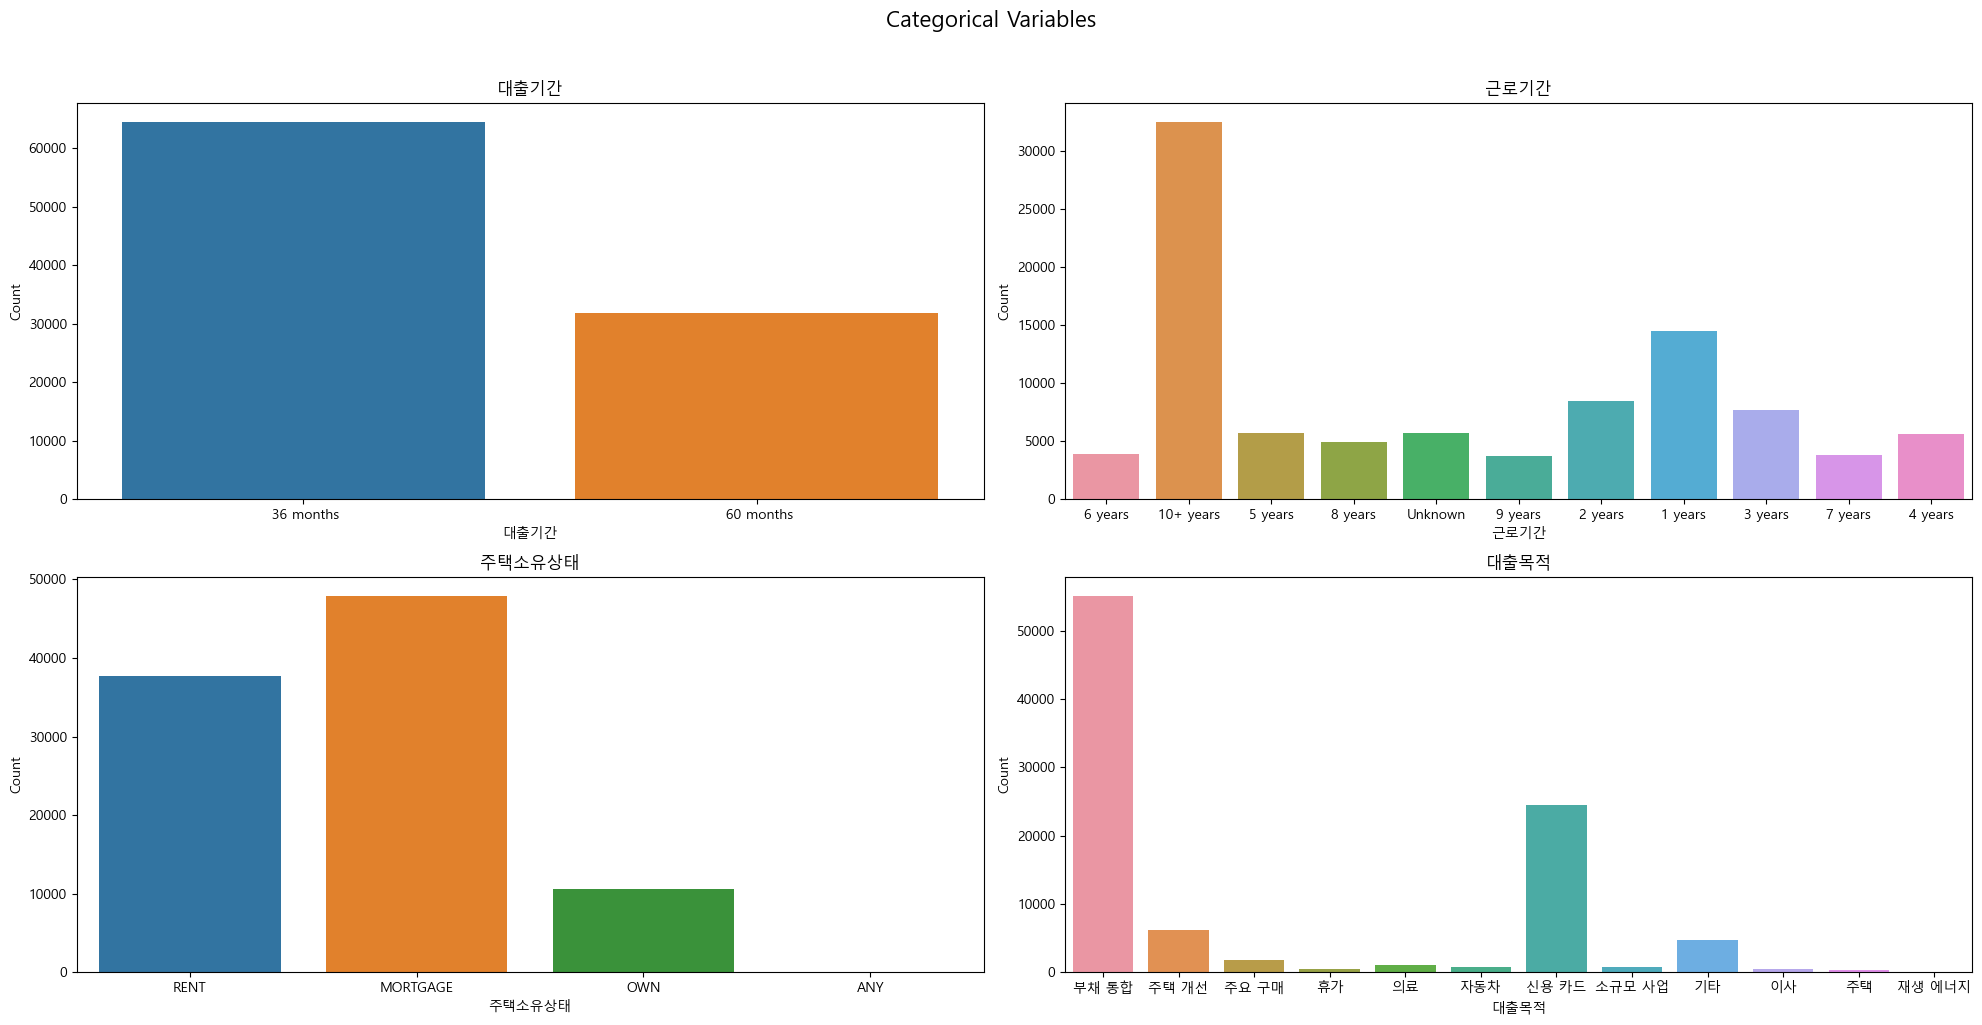

In [16]:
# Calculate the index to drop, the category columns (excluding the first and last)
drop_last = len(cat_col) - 1
category_col_name = cat_col[1:drop_last]

# Calculate the total number of categorical columns and rows needed for the subplot grid
total_category_cols = len(category_col_name)
rows = (total_category_cols + 1) // 2
cols = 2

# Set up the subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
fig.suptitle("Categorical Variables ", y=1.02, fontsize=16)

# Visualize count plots for each categorical variable
for i, c in enumerate(category_col_name):
    row = i // cols
    col = i % cols
    sns.countplot(data=train, x=c, ax=axes[row, col])
    axes[row, col].set_title(f"{c}")
    axes[row, col].set_xlabel(c)
    axes[row, col].set_ylabel("Count")

# Hide any remaining subplots if there are unused slots
for i in range(total_category_cols, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

# Adjust the layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

#### 2. Categorical Variables by the "대출등급"


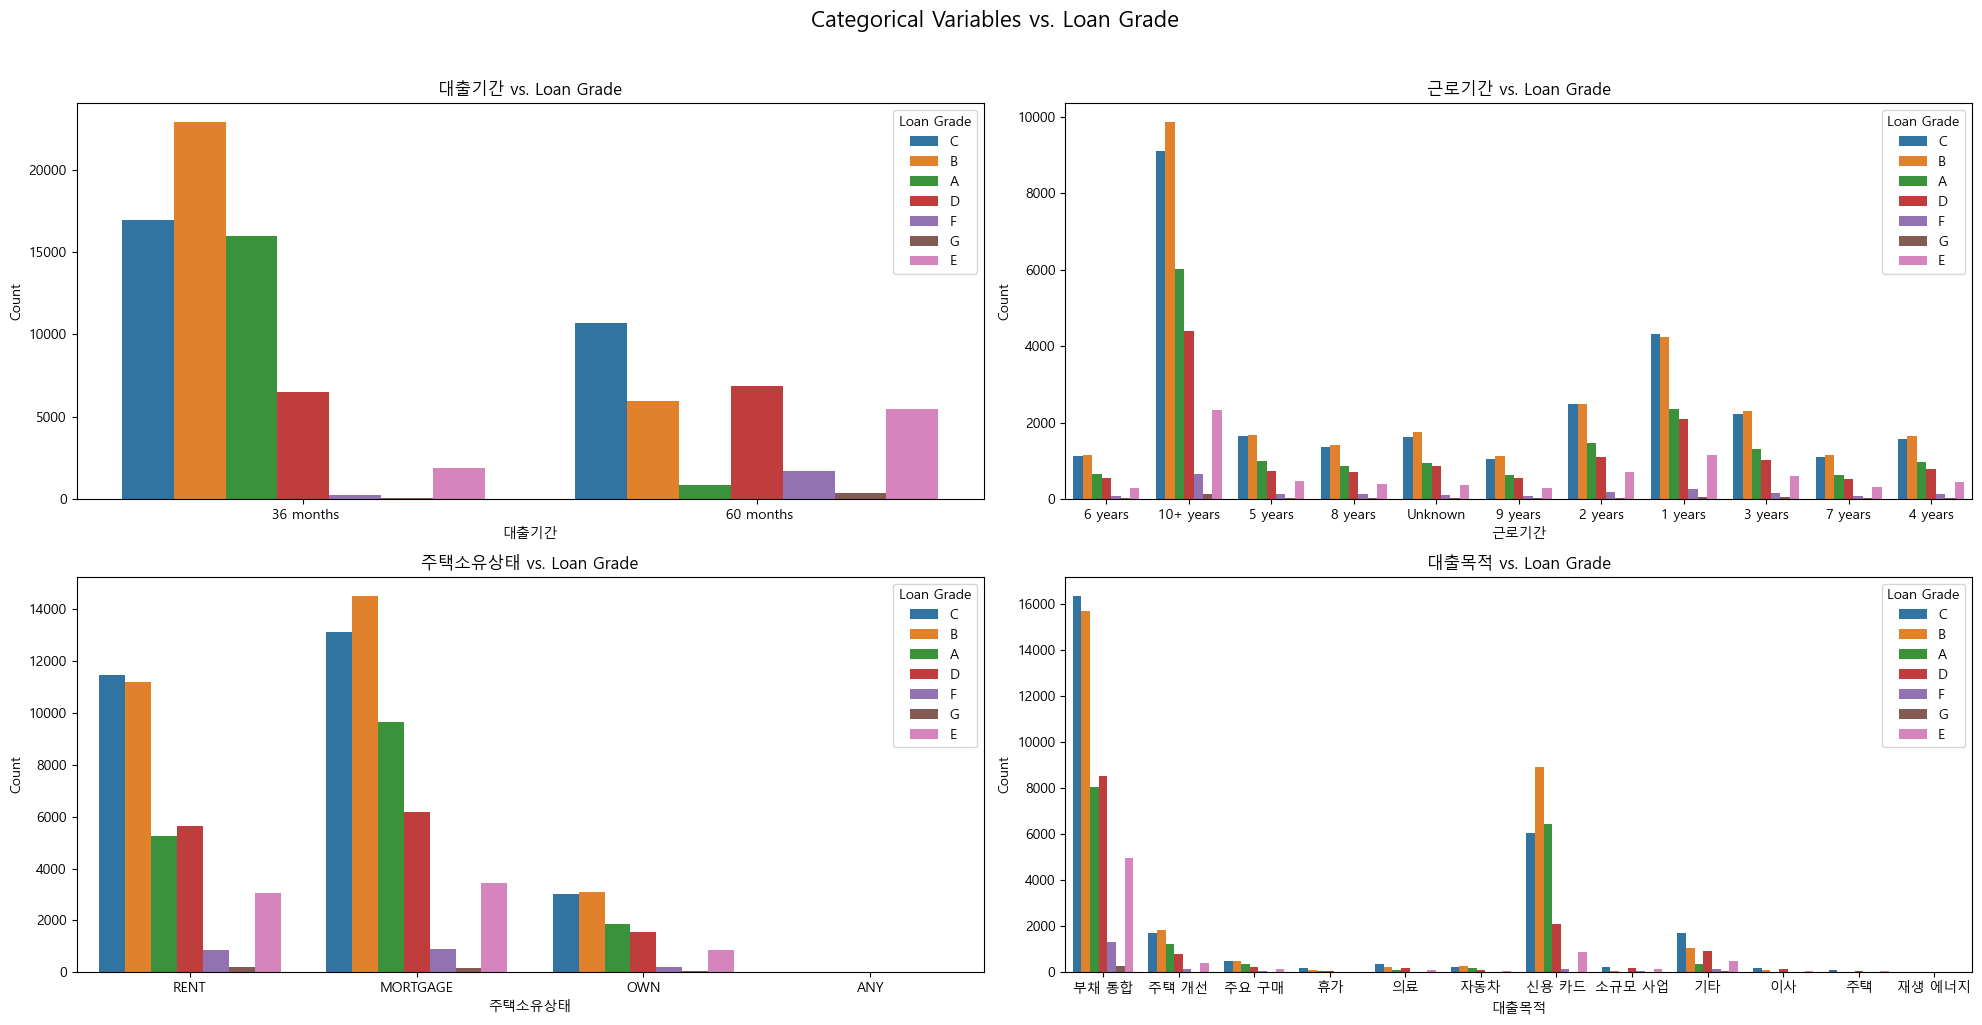

In [17]:
# Calculate the index to drop, the category columns (excluding the first and last)
drop_last = len(cat_col) - 1
category_col_name = cat_col[1:drop_last]

# Calculate the total number of categorical columns and rows needed for the subplot grid
total_category_cols = len(category_col_name)
rows = (total_category_cols + 1) // 2
cols = 2

# Set up the subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
fig.suptitle("Categorical Variables vs. Loan Grade", y=1.02, fontsize=16)

# Visualize count plots for each categorical variable with loan grade as hue
for i, c in enumerate(category_col_name):
    row = i // cols
    col = i % cols
    sns.countplot(data=train, x=c, hue="대출등급", ax=axes[row, col])
    axes[row, col].set_title(f"{c} vs. Loan Grade")
    axes[row, col].set_xlabel(c)
    axes[row, col].set_ylabel("Count")
    axes[row, col].legend(title="Loan Grade", loc="upper right")

# Hide any remaining subplots if there are unused slots
for i in range(total_category_cols, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

# Adjust the layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

#### 3. Numerical Variables


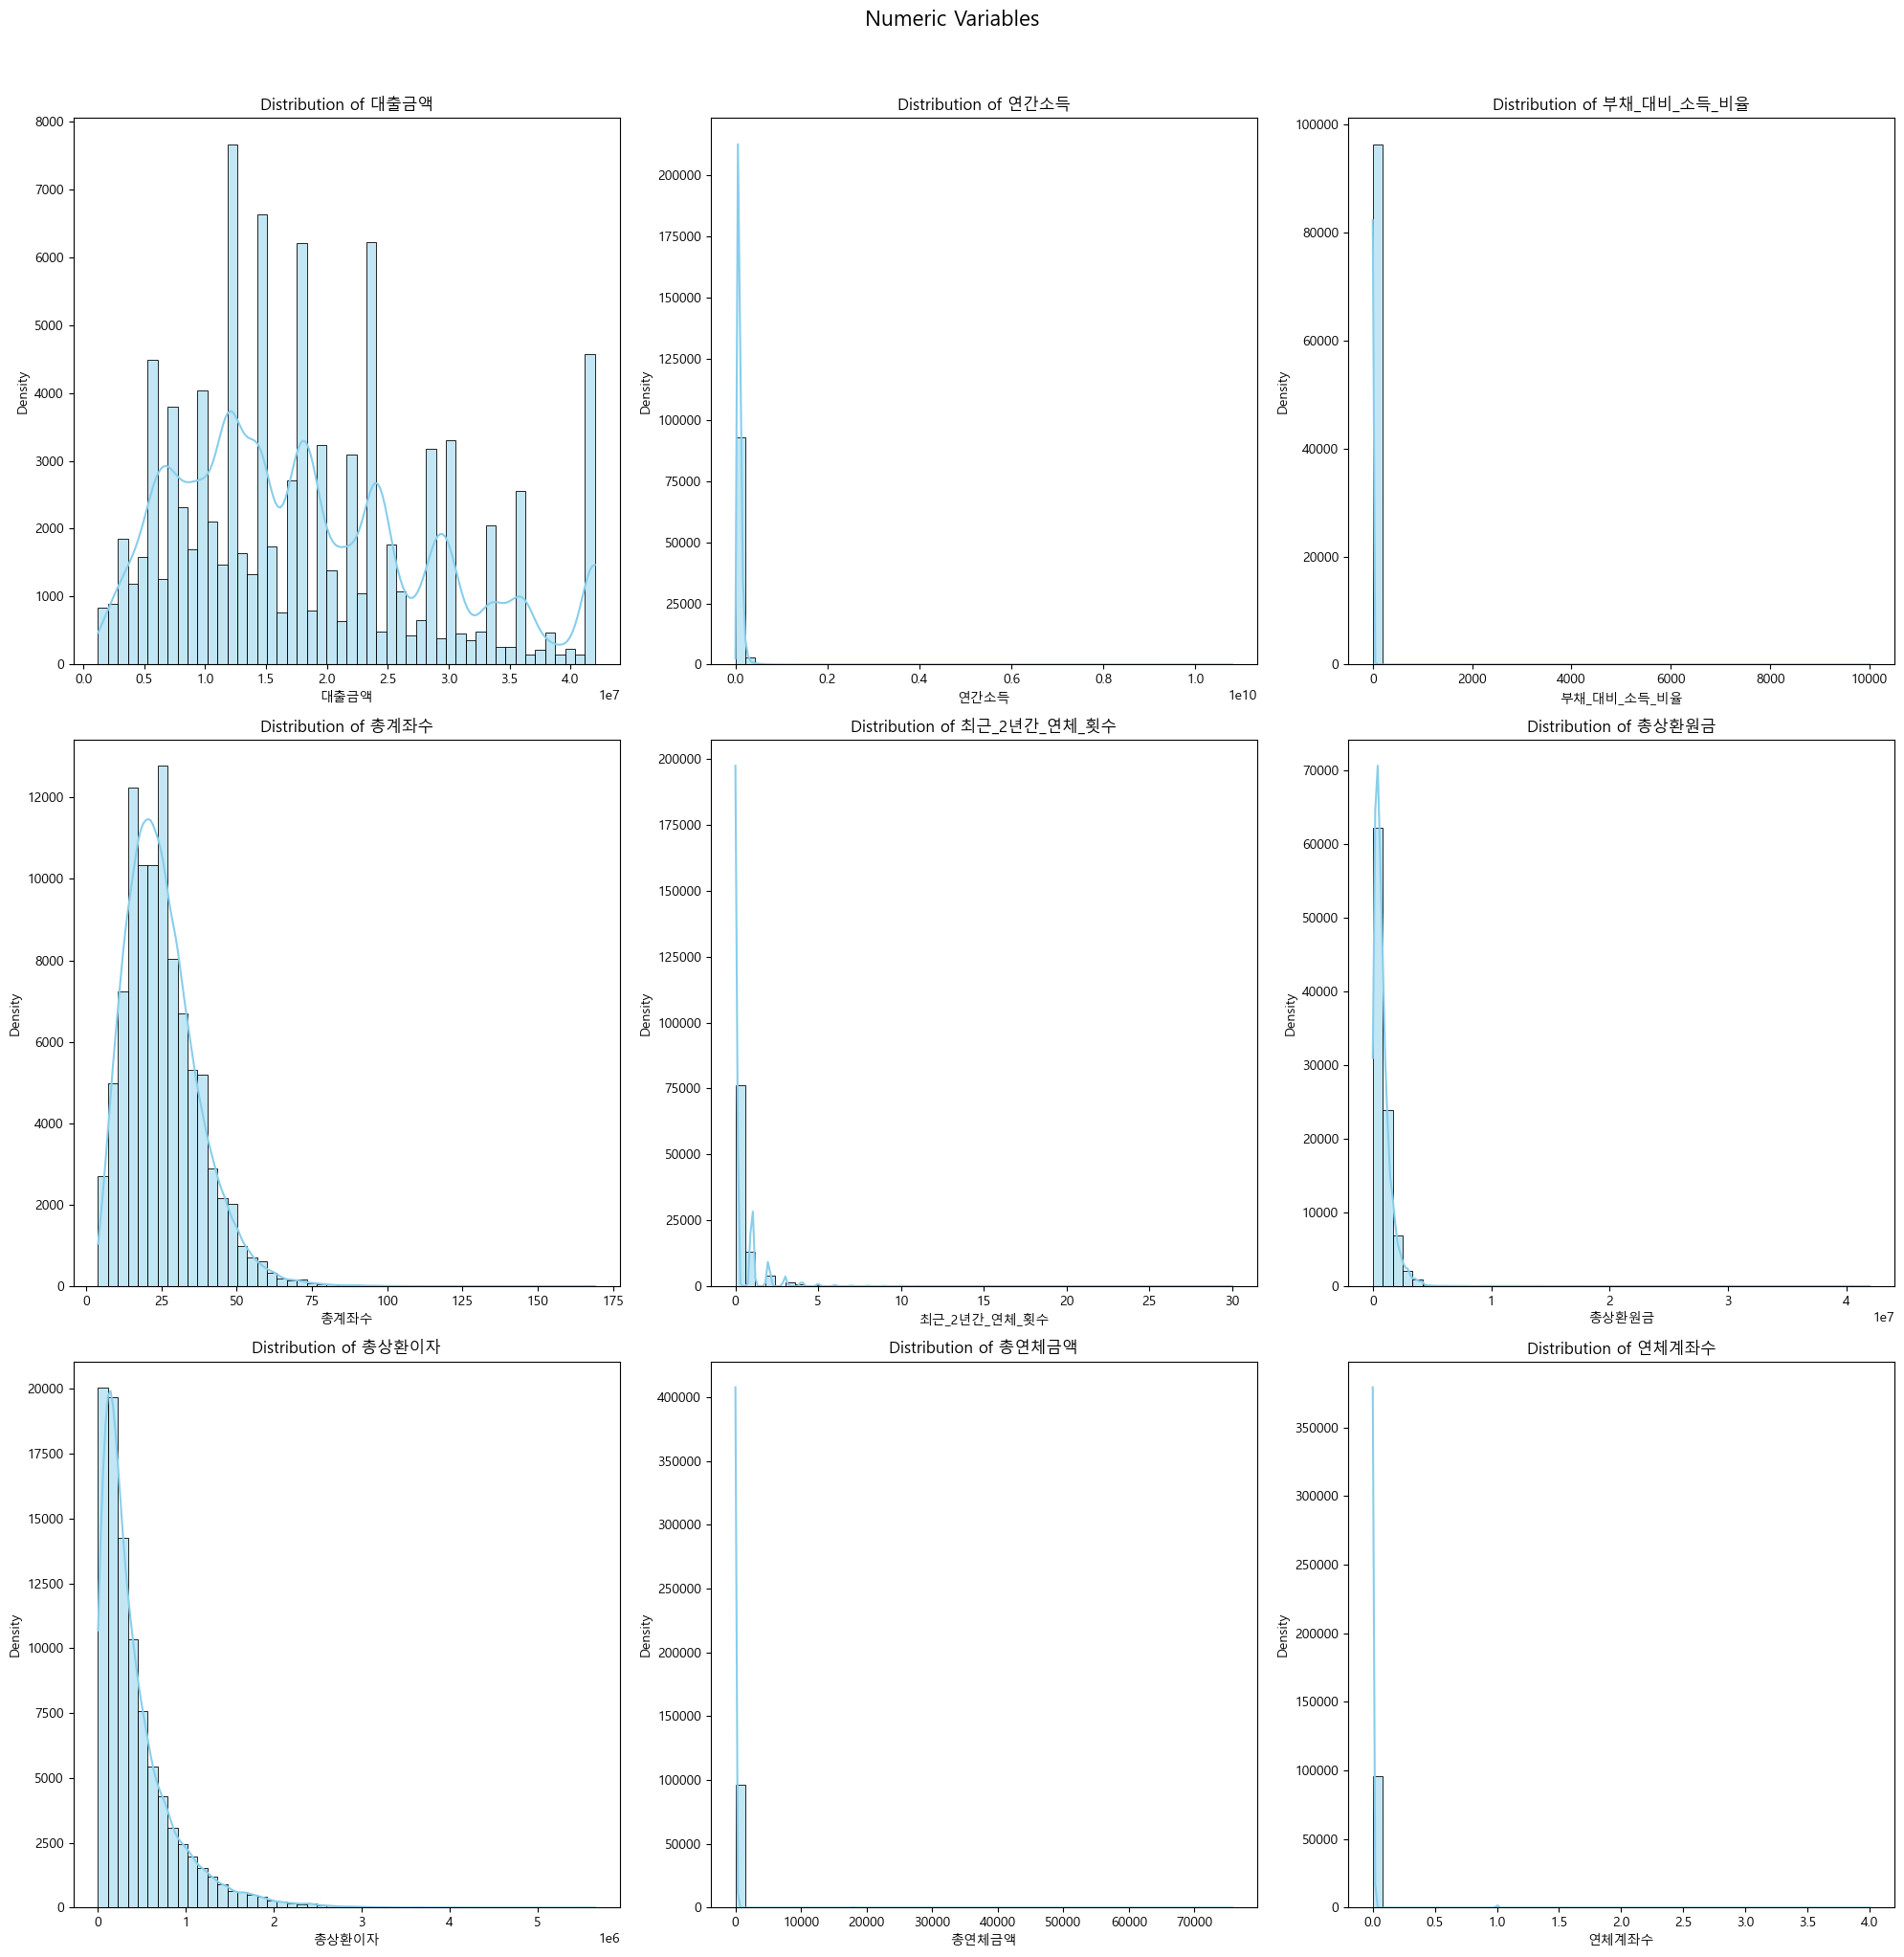

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns
numeric_columns = train.select_dtypes(include=["number"]).columns
total_category_cols = len(numeric_columns)
rows = 3
cols = 3

# Set up the visualization
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
fig.suptitle("Numeric Variables", y=1.02, fontsize=16)

# Visualize the distribution of numeric variables with respect to loan grade
for i, col_name in enumerate(numeric_columns):
    row = i // cols
    col = i % cols
    # Use histplot with adjusted bins, kde, and color
    sns.histplot(
        data=train,
        x=col_name,
        ax=axes[row, col],
        kde=True,
        bins=50,
        color="skyblue",
    )

    # Set title and labels for each subplot
    axes[row, col].set_title(f"Distribution of {col_name}")
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel("Density")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### 4. Crorrelation among numercial varables


In [19]:
cor = train[numeric_columns].corr()
cor

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
대출금액,1.000000,0.273975,0.002263,0.212309,-0.014775,0.379061,0.615680,0.011853,0.000182
연간소득,0.273975,1.000000,-0.044594,0.145403,0.040260,0.137552,0.114311,0.000333,0.009854
부채_대비_소득_비율,0.002263,-0.044594,1.000000,0.058830,0.000699,-0.016180,0.018565,0.000711,0.000051
총계좌수,0.212309,0.145403,0.058830,1.000000,0.112092,0.083615,0.116299,0.000037,0.023652
최근_2년간_연체_횟수,-0.014775,0.040260,0.000699,0.112092,1.000000,-0.010048,0.008095,0.004612,0.133632
총상환원금,0.379061,0.137552,-0.016180,0.083615,-0.010048,1.000000,0.412385,0.015379,-0.005190
총상환이자,0.615680,0.114311,0.018565,0.116299,0.008095,0.412385,1.000000,0.057838,0.009257
총연체금액,0.011853,0.000333,0.000711,0.000037,0.004612,0.015379,0.057838,1.000000,0.006620
연체계좌수,0.000182,0.009854,0.000051,0.023652,0.133632,-0.005190,0.009257,0.006620,1.000000


<AxesSubplot: >

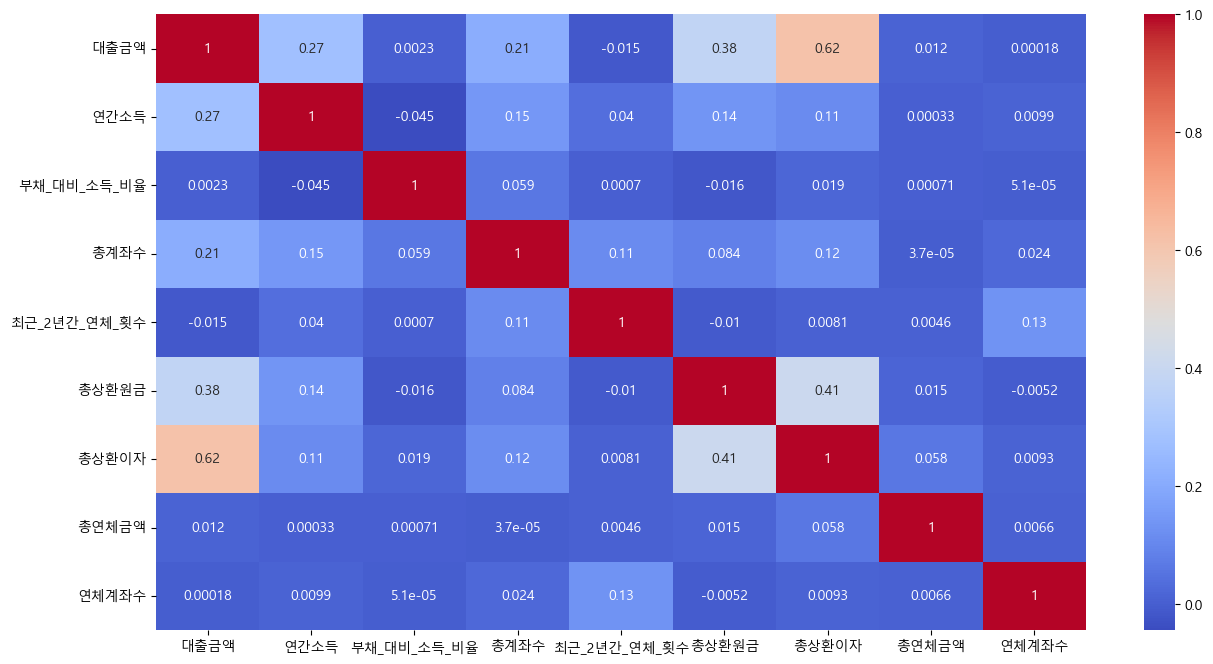

In [20]:
plt.figure(figsize=(15, 8))
sns.heatmap(cor, annot=True, cmap="coolwarm")

#### 5. Scattor Plot among numerical variables


In [21]:
# sns.pairplot(train[numeric_columns])
# plt.show()

## 3. Feature Engineering


#### 1. Feature Engineering - Numerical Variable


##### Missing Value 찾기


In [22]:
count_na = train.isna().sum()
count_na

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

<AxesSubplot: >

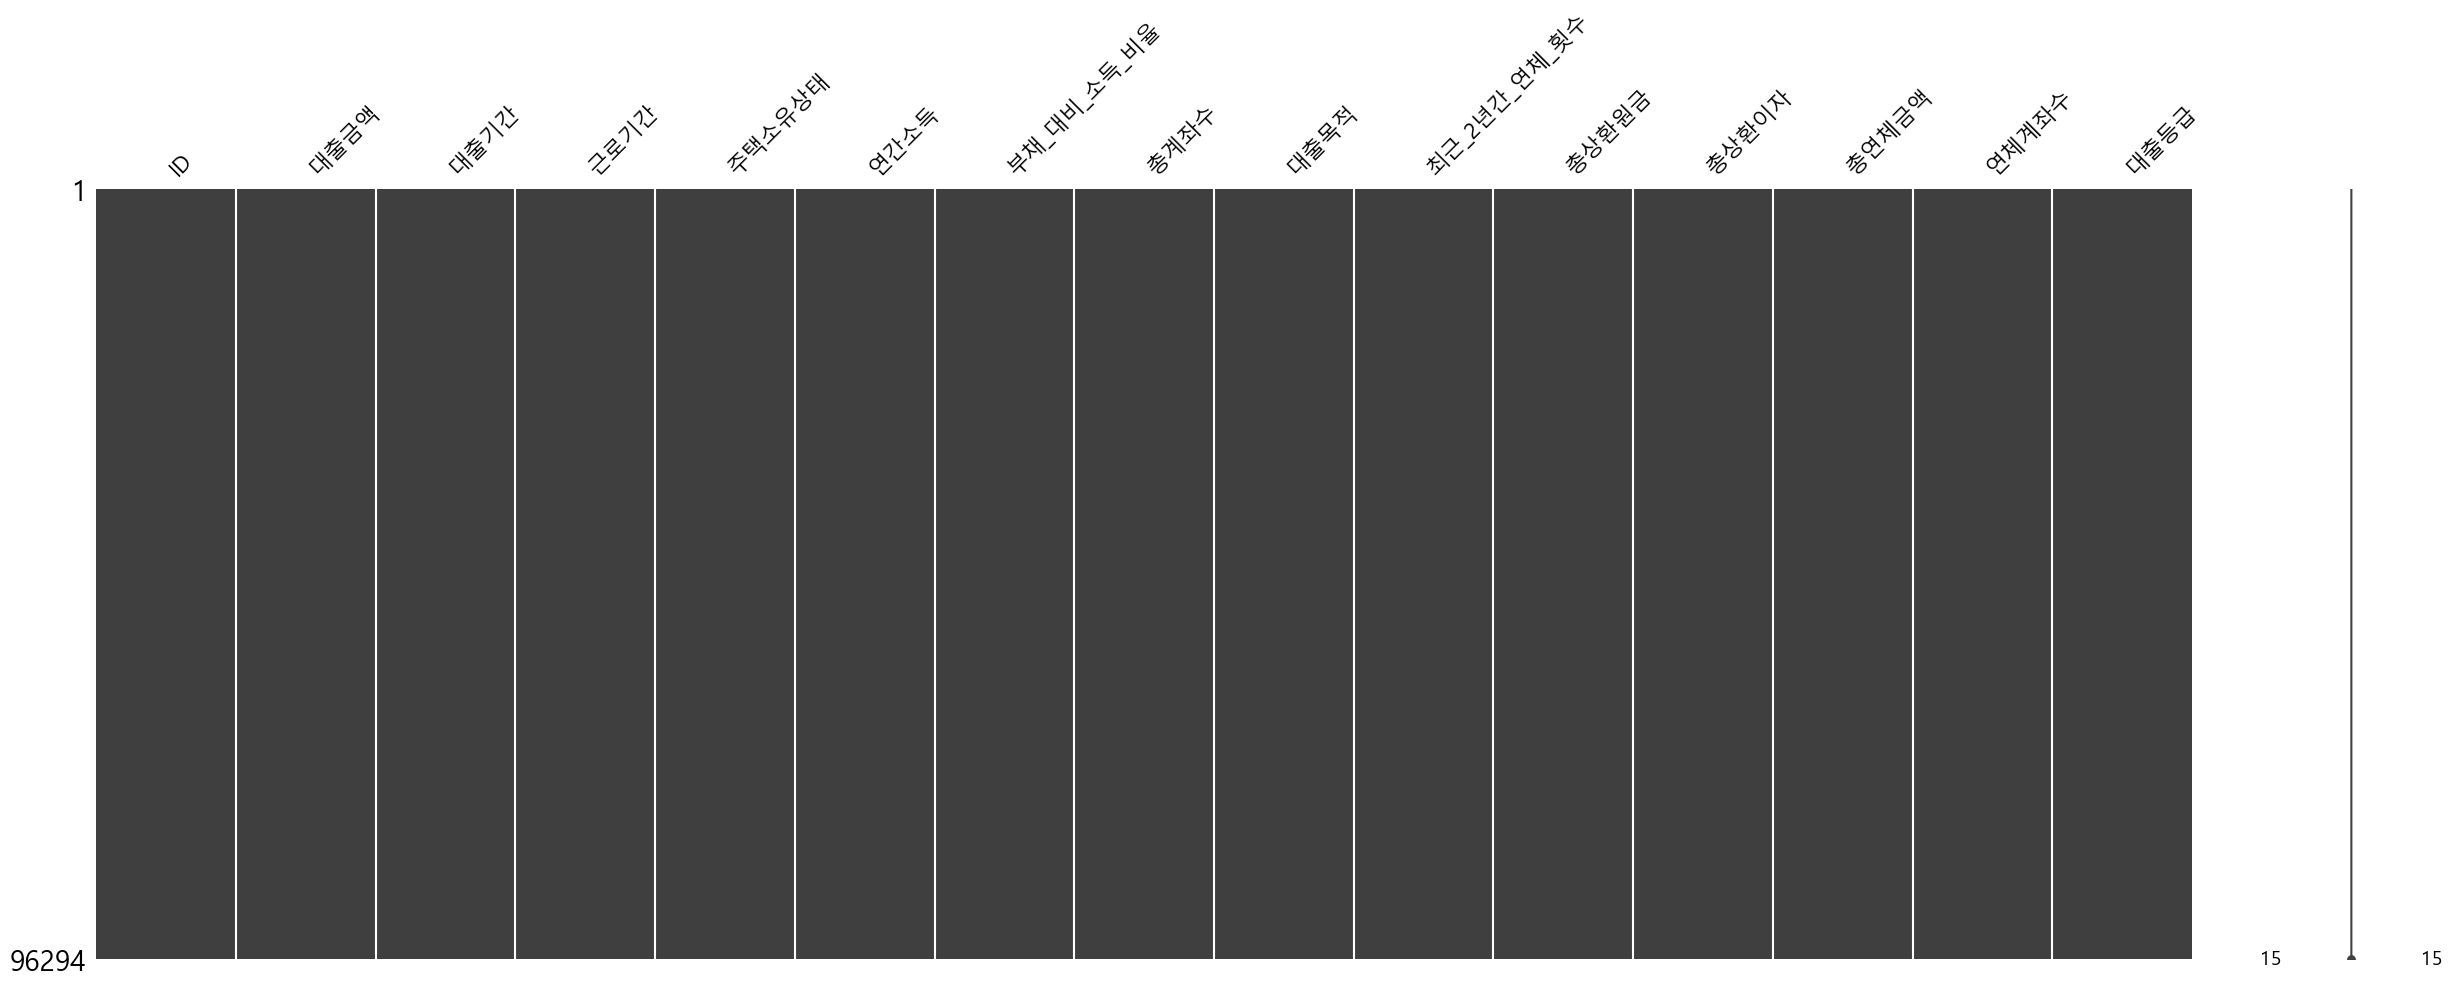

In [23]:
import missingno


missingno.matrix(train, figsize=(30, 10))

In [24]:
count_na2 = test.isna().sum()
count_na2

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
dtype: int64

<AxesSubplot: >

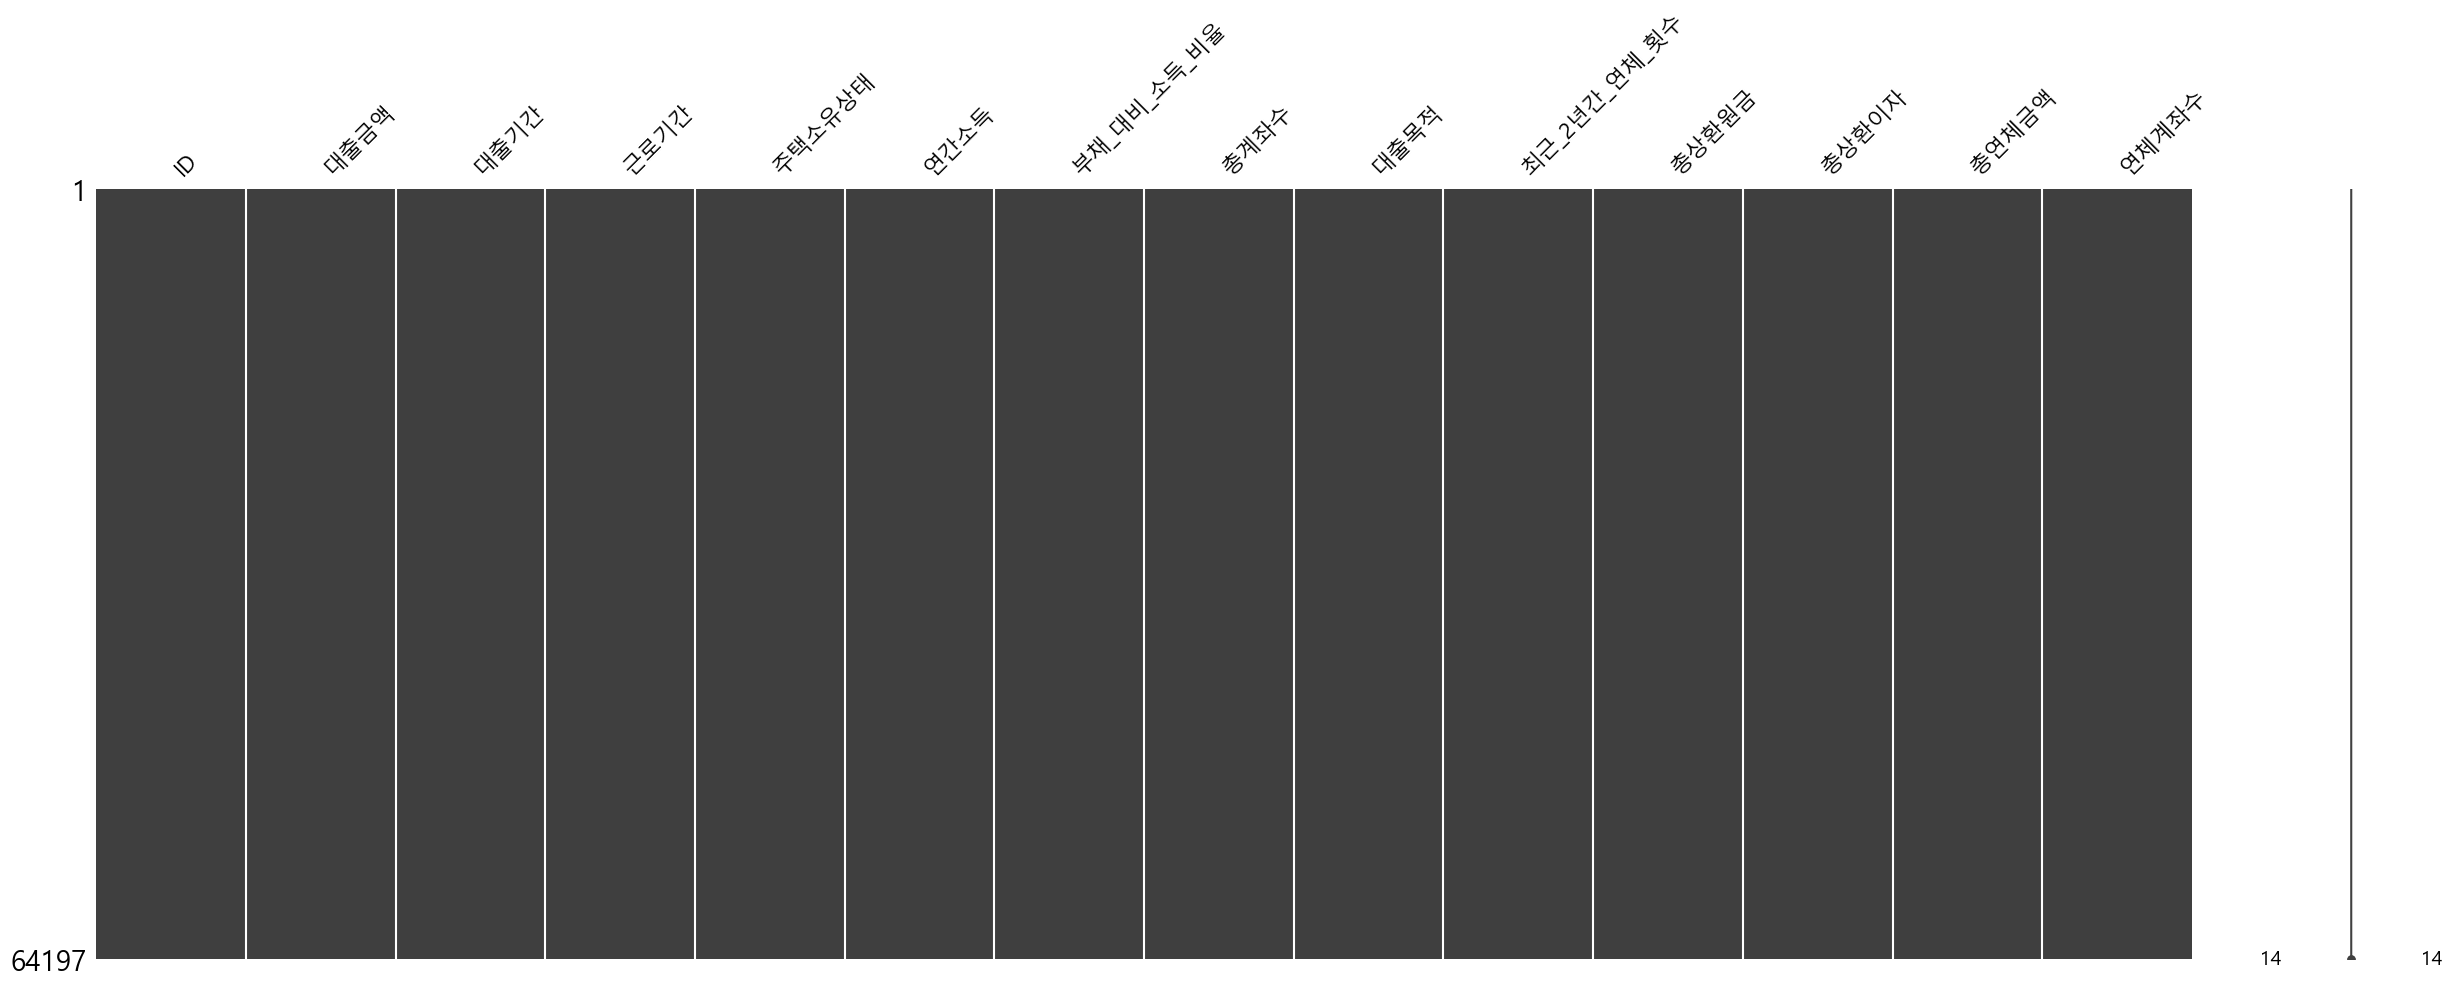

In [25]:
missingno.matrix(test, figsize=(30, 10))

##### 중복된 행 여부 찾기


In [26]:
train.duplicated().sum()

0

In [27]:
test.duplicated().sum()

0

##### 이상치 확인


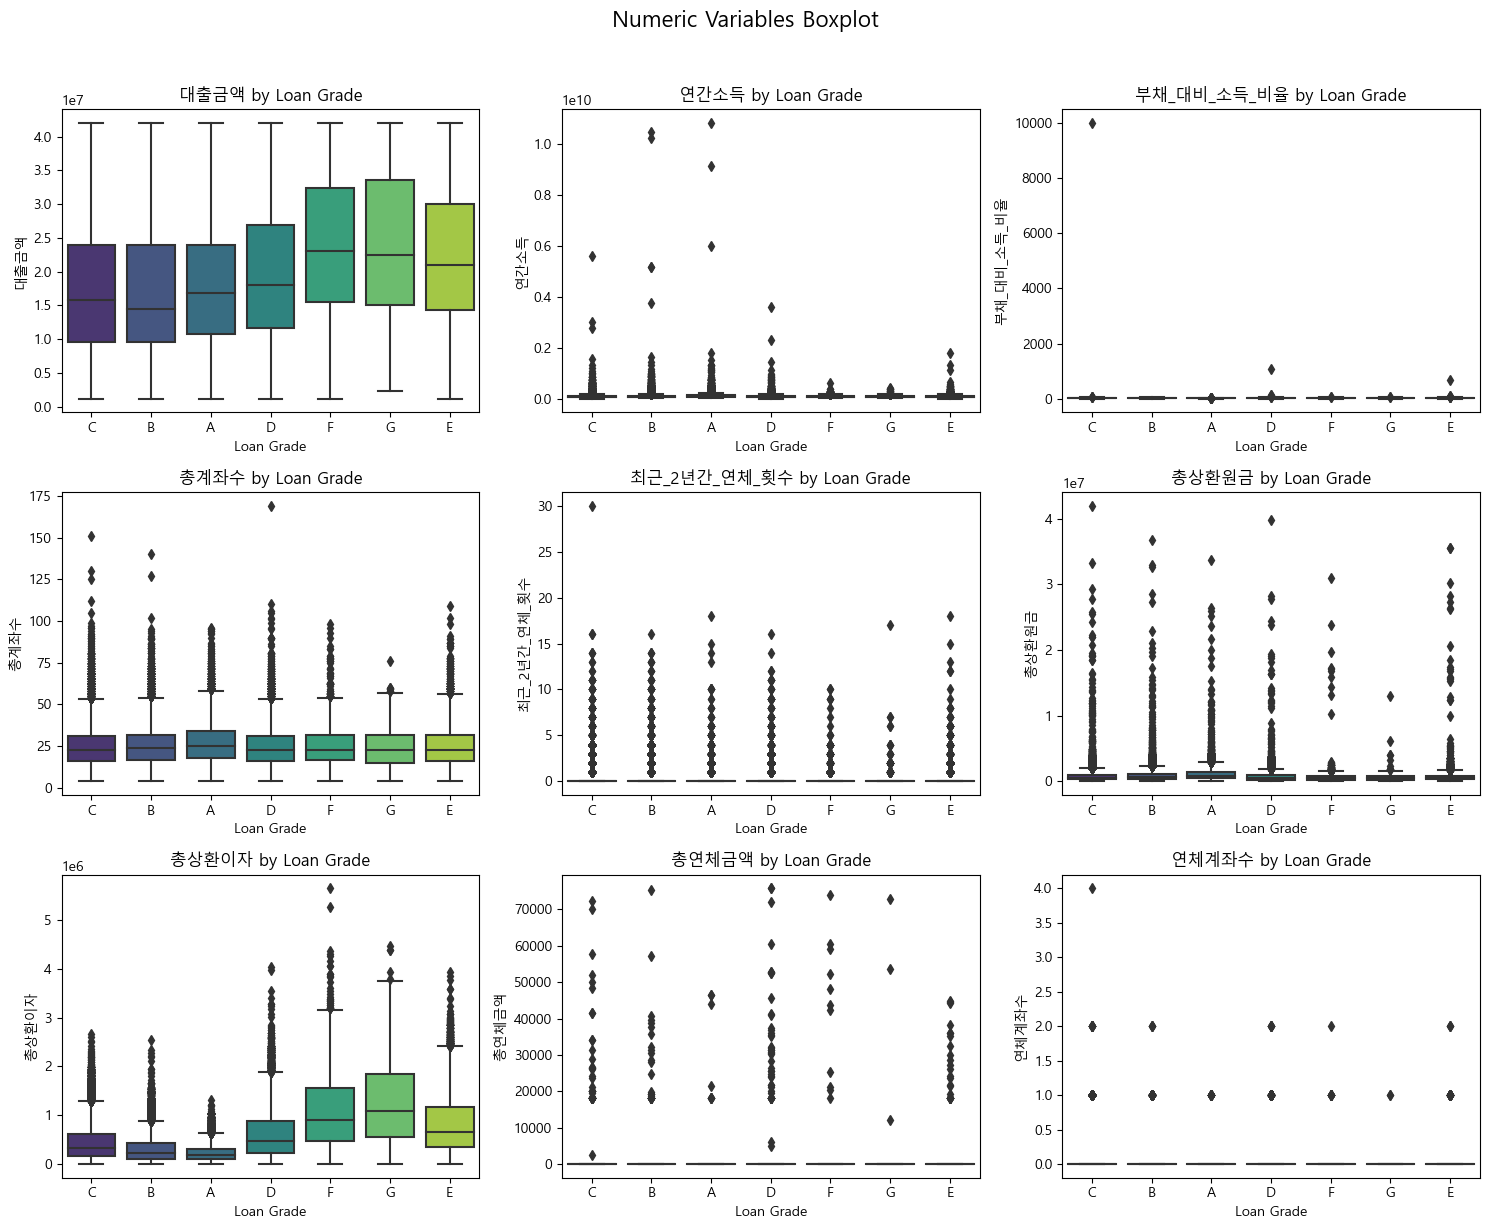

In [28]:
numeric_columns = train.select_dtypes(include=["number"]).columns

# Set up the visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Numeric Variables Boxplot", y=1.02, fontsize=16)

# Visualize the distribution of numeric variables grouped by loan grade
for i in range(3):
    for j, col in enumerate(numeric_columns[i * 3: i * 3 + 3]):
        sns.boxplot(data=train, x="대출등급", y=col,
                    ax=axes[i, j], palette="viridis")

        # Set title and labels for each subplot
        axes[i, j].set_title(f"{col} by Loan Grade")
        axes[i, j].set_xlabel("Loan Grade")
        axes[i, j].set_ylabel(col)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### 2. Feature Engineering - Categorical Varible


In [29]:
cat_col = train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_col

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급']

##### One-Hot Encoding


In [30]:
# Initialize OneHotEncoder with specified parameters
home_ownership_encoder = OneHotEncoder(sparse=False, drop="first")
train = train[train["주택소유상태"] != "ANY"]
train = train.reset_index(drop=True)
# Apply one-hot encoding to the "주택소유상태" column in the training set
home_ownership_encoded = home_ownership_encoder.fit_transform(
    train[["주택소유상태"]])

# Concatenate the encoded columns to the original DataFrame for the training set
train_encoded = pd.concat(
    [train, pd.DataFrame(home_ownership_encoded, columns=["RENT", "OWN"])],
    axis=1,
)
test = test[test["주택소유상태"] != "ANY"]
test = test.reset_index(drop=True)

# Apply one-hot encoding to the "주택소유상태" column in the test set
home_ownership_encoded_test = home_ownership_encoder.transform(
    test[["주택소유상태"]])

# Concatenate the encoded columns to the original DataFrame for the test set
test_encoded = pd.concat(
    [test, pd.DataFrame(home_ownership_encoded_test, columns=["RENT", "OWN"])],
    axis=1,
)

# Drop the original "주택소유상태" column from both the training and test sets
train.drop("주택소유상태", axis=1, inplace=True)
test.drop("주택소유상태", axis=1, inplace=True)

In [31]:
# Initialize OneHotEncoder with specified parameters
loan_purpose_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

# Apply one-hot encoding to the "대출목적" column in the training set
loan_purpose_encoded_train = loan_purpose_encoder.fit_transform(train[[
                                                                "대출목적"]])

# Apply one-hot encoding to the "대출목적" column in the test set
loan_purpose_encoded_test = loan_purpose_encoder.transform(test[["대출목적"]])

# Concatenate the encoded columns to the original DataFrame for the training set
train = pd.concat(
    [
        train,
        pd.DataFrame(
            loan_purpose_encoded_train,
            columns=loan_purpose_encoder.get_feature_names_out(["대출목적"]),
        ),
    ],
    axis=1,
)

# Concatenate the encoded columns to the original DataFrame for the test set
test = pd.concat(
    [
        test,
        pd.DataFrame(
            loan_purpose_encoded_test,
            columns=loan_purpose_encoder.get_feature_names_out(["대출목적"]),
        ),
    ],
    axis=1,
)

# Drop the original "대출목적" column from both the training and test sets
train.drop("대출목적", axis=1, inplace=True)
test.drop("대출목적", axis=1, inplace=True)

##### Ordinal Encoder


In [32]:
# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Apply ordinal encoding to the "대출기간" column in the training set
train["대출기간"] = ordinal_encoder.fit_transform(train[["대출기간"]])

# Apply ordinal encoding to the "대출기간" column in the test set
test["대출기간"] = ordinal_encoder.transform(test[["대출기간"]])

In [33]:
# Define the mapping dictionary for employment length
employment_mapping = {
    "Unknown": 0,
    "1 years": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

# Apply the mapping to the "근로기간" column in the training set
train["근로기간"] = train["근로기간"].map(employment_mapping)

# Apply the mapping to the "근로기간" column in the test set
test["근로기간"] = test["근로기간"].map(employment_mapping)

In [34]:
# Define the mapping dictionary for loan grade
grade_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

# Apply the mapping to the "대출등급" column in the training set
train["대출등급"] = train["대출등급"].map(grade_mapping)

In [35]:
# Create new columns in the train dataset
train["원금/대출"] = train["총상환원금"] / train["대출금액"] * 100
train["이자/대출"] = train["총상환이자"] / train["대출금액"]*100

train['연체비율'] = (train['총연체금액'] / train['대출금액']) * 100
test['연체비율'] = (test['총연체금액'] / test['대출금액']) * 100

train['총이자비율'] = (train['총상환이자'] / train['대출금액']) * 100
test['총이자비율'] = (test['총상환이자'] / test['대출금액']) * 100

# Create new columns in the test dataset
test["원금/대출"] = test["총상환원금"] / test["대출금액"]*100
test["이자/대출"] = test["총상환이자"] / test["대출금액"]*100

In [36]:
train["상환비율"] = (
    ((train["총상환원금"] + train["총상환이자"]) / train["대출금액"]) * 100
)


train["월평균소득"] = train["연간소득"] / 12

In [37]:
# 상환비율 계산
test["상환비율"] = ((test["총상환원금"] + test["총상환이자"]) / test["대출금액"])*100
# 월평균소득 계산
test["월평균소득"] = test["연간소득"] / 12

In [38]:
train.head()

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가,원금/대출,이자/대출,연체비율,총이자비율,상환비율,월평균소득
0,TRAIN_00000,12480000,0.0,6,72000000,18.90,15,0,0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,6000000.0
1,TRAIN_00001,14400000,1.0,10,130800000,22.33,21,0,373572,234060.0,...,0.0,0.0,1.0,0.0,2.594250,1.625417,0.0,1.625417,4.219667,10900000.0
2,TRAIN_00002,12000000,0.0,5,96000000,8.60,14,0,928644,151944.0,...,0.0,0.0,0.0,0.0,7.738700,1.266200,0.0,1.266200,9.004900,8000000.0
3,TRAIN_00003,14400000,0.0,8,132000000,15.09,15,0,325824,153108.0,...,0.0,0.0,0.0,0.0,2.262667,1.063250,0.0,1.063250,3.325917,11000000.0
4,TRAIN_00004,18000000,1.0,0,71736000,25.39,19,0,228540,148956.0,...,1.0,0.0,0.0,0.0,1.269667,0.827533,0.0,0.827533,2.097200,5978000.0


In [39]:
train.shape

(96293, 31)

In [40]:
test.shape

(64197, 30)

## 4. Data Splitting


In [41]:
# Drop the "ID" column from the training data
train = train.drop("ID", axis=1)

# Separate features (X) and target variable (y)
X, y = train.drop("대출등급", axis=1).copy(), train["대출등급"].copy()

In [42]:
train["대출등급"].value_counts()

1    28817
2    27622
0    16772
3    13354
4     7354
5     1954
6      420
Name: 대출등급, dtype: int64

The code train["대출등급"].value_counts() is used to quickly check for data imbalance in the "대출등급" (Loan Grade) column. It helps assess whether there is an uneven distribution of instances across different loan grades in the dataset, which is crucial for addressing potential biases in machine learning models.


#### 1. Oversampling

Over-sampling is a technique used to address class imbalance in machine learning datasets by increasing the number of instances in the minority class. The goal is to create a more balanced dataset, preventing the model from being biased towards the majority class. Various over-sampling methods exist, and one common approach is the Synthetic Minority Over-sampling Technique (SMOTE).


In [43]:
# # Create an instance of SMOTE with a specified random seed
# smote = SMOTE(random_state=42)

# # Apply SMOTE to the training data to perform oversampling
# X, y = smote.fit_resample(X, y)

#### 2. Undersampling

Under-sampling is another technique used to address class imbalance in machine learning datasets. Unlike over-sampling, under-sampling focuses on reducing the number of instances in the majority class to achieve a more balanced dataset.


In [44]:
# rus = RandomUnderSampler(random_state=10)
# X_train_resampled, y_train_resampled = rus.fit_resample(X, y)

##### Data Scaling

After experimenting with various scalers, including RobustScaler and StandardScaler, I found that MinMaxScaler consistently produced the best performance for my dataset. As a result, I opted to use MinMaxScaler for feature scaling in my machine learning workflow.


In [45]:
# # Create an instance of StandardScaler
# scaler = StandardScaler()

# # Fit and transform the training data
# X_train_scaled = scaler.fit_transform(X_train)

# # Transform the test data using the same scaler
# X_test_scaled = scaler.transform(X_test)

In [46]:
# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the training data
# X = scaler.fit_transform(X)

In [47]:
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## 5. Training and Evaluating the Model


#### Decision Tree, Random Forest, XGBoost


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(

    X, y, test_size=0.2, random_state=42)

# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_val)
f1_dt = f1_score(y_val, y_pred_dt, average="macro")
print("Decision Tree Validation F1 Score:", f1_dt)

# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_val)
f1_rf = f1_score(y_val, y_pred_rf, average="macro")
print("Random Forest Validation F1 Score:", f1_rf)

# XGBoost
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_val)
f1_xgb = f1_score(y_val, y_pred_xgb, average="macro")
print("XGBoost Validation F1 Score:", f1_xgb)

Decision Tree Validation F1 Score: 0.9274319289013359
Random Forest Validation F1 Score: 0.9216426876388814
XGBoost Validation F1 Score: 0.9121719036662984


#### Hyperparameter Tuning


In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_val)
f1_dt = f1_score(y_val, y_pred_dt, average="macro")
print("Decision Tree Validation F1 Score:", f1_dt)
feature_importances = dt_classifier.feature_importances_

# Get indices of the top 6 features
top_feature_indices = feature_importances.argsort()[-5:][::-1]
features = []
print("Top 6 Features and Their Importances:")
for index in top_feature_indices:
    feature = train.drop("대출등급", axis=1).columns[index]
    importance = feature_importances[index]
    features.append(feature)
    print(f"{feature}: {importance}")
X, y = train.drop("대출등급", axis=1).copy(), train["대출등급"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X[features], y, test_size=0.3, random_state=42
)

Decision Tree Validation F1 Score: 0.9237146030431429
Top 6 Features and Their Importances:
원금/대출: 0.617294371297948
총이자비율: 0.12266029997794173
이자/대출: 0.11446970086367252
대출기간: 0.04077498401621911
상환비율: 0.038232532646660634


In [51]:
# Create a Decision Tree classifier
from sklearn.metrics import make_scorer


dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Use F1 score as the scoring metric
f1_scorer = make_scorer(f1_score, average="macro")

# Initialize GridSearchCV
grid_search = GridSearchCV(dt_classifier, param_grid, scoring=f1_scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding F1 score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

# Get the best model from the grid search
best_dt_model = grid_search.best_estimator_

# Evaluate the model on the validation set
y_pred = best_dt_model.predict(X_val)
validation_f1 = f1_score(y_val, y_pred, average="macro")
print("Validation F1 Score: ", validation_f1)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1 Score:  0.9450364400211138
Validation F1 Score:  0.9433133796685037


In [ ]:
# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(

#     X, y, test_size=0.3, random_state=42)

# xgb_classifier = XGBClassifier(random_state=42)
# xgb_classifier.fit(X_train, y_train)
# y_pred_xgb = xgb_classifier.predict(X_val)
# f1_xgb = f1_score(y_val, y_pred_xgb, average="macro")
# print("XGBoost Validation F1 Score:", f1_xgb)
# feature_importances = xgb_classifier.feature_importances_

# # Get indices of the top 6 features
# top_feature_indices = feature_importances.argsort()[-5:][::-1]
# features = []
# print("Top 6 Features and Their Importances:")
# for index in top_feature_indices:
#     feature = train.drop("대출등급", axis=1).columns[index]
#     importance = feature_importances[index]
#     features.append(feature)
#     print(f"{feature}: {importance}")
# X, y = train.drop("대출등급", axis=1).copy(), train["대출등급"].copy()

# X_train, X_val, y_train, y_val = train_test_split(
#     X[features], y, test_size=0.3, random_state=42
# )

XGBoost Validation F1 Score: 0.9100168120905205
Top 6 Features and Their Importances:
원금/대출: 0.37913060188293457
이자/대출: 0.2508166432380676
상환비율: 0.14191392064094543
대출기간: 0.08052182197570801
대출목적_신용 카드: 0.013469708152115345
XGBoost Validation F1 Score: 0.9224793714976707


In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.model_selection import train_test_split

# # Assuming you already have X_train, X_val, y_train, y_val

# # Create an XGBoost classifier
# xgb_classifier = XGBClassifier(random_state=42)

# # Define the hyperparameters to tune
# param_grid_xgb = {
#     "learning_rate": [0.01, 0.1, 0.2],
#     "n_estimators": [50, 100, 200],
#     "max_depth": [3, 5, 7],
#     "gamma": [0, 0.1, 0.2],
# }

# # Use F1 score as the scoring metric
# f1_scorer = make_scorer(f1_score, average="macro")

# # Initialize GridSearchCV
# grid_search_xgb = GridSearchCV(

#     xgb_classifier, param_grid_xgb, scoring=f1_scorer, cv=5)

# # Fit the grid search to the data
# grid_search_xgb.fit(X_train, y_train)

# # Print the best parameters and corresponding F1 score
# print("XGBoost Best Parameters: ", grid_search_xgb.best_params_)
# print("XGBoost Best F1 Score: ", grid_search_xgb.best_score_)

# # Get the best model from the grid search
# best_xgb_model = grid_search_xgb.best_estimator_

# # Evaluate the model on the validation set
# y_pred_xgb = best_xgb_model.predict(X_val)
# validation_f1_xgb = f1_score(y_val, y_pred_xgb, average="macro")
# print("XGBoost Validation F1 Score: ", validation_f1_xgb)

XGBoost Best Parameters:  {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}
XGBoost Best F1 Score:  0.9137285692938981
XGBoost Validation F1 Score:  0.9150077439320888


In [ ]:
# # Random Forest

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.3, random_state=42)
# rf_classifier = RandomForestClassifier(random_state=42)
# rf_classifier.fit(X_train, y_train)
# y_pred_rf = rf_classifier.predict(X_val)
# f1_rf = f1_score(y_val, y_pred_rf, average="macro")
# print("Random Forest Validation F1 Score:", f1_rf)
# feature_importances = rf_classifier.feature_importances_

# # Get indices of the top 6 features
# top_feature_indices = feature_importances.argsort()[-5:][::-1]
# features = []
# print("Top 6 Features and Their Importances:")
# for index in top_feature_indices:
#     feature = train.drop("대출등급", axis=1).columns[index]
#     importance = feature_importances[index]
#     features.append(feature)
#     print(f"{feature}: {importance}")
# X, y = train.drop("대출등급", axis=1).copy(), train["대출등급"].copy()

# X_train, X_val, y_train, y_val = train_test_split(
#     X[features], y, test_size=0.3, random_state=42
# )

Random Forest Validation F1 Score: 0.9154179166914973
Top 6 Features and Their Importances:
원금/대출: 0.31826903434144294
총이자비율: 0.14962755963807306
상환비율: 0.1492746865942163
이자/대출: 0.1424138885760314
총상환원금: 0.05123384487831947
Random Forest Validation F1 Score: 0.9366103957003798


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.model_selection import train_test_split

# # Assuming you already have X_train, X_val, y_train, y_val

# # Create a Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Define the hyperparameters to tune
# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],

# }

# # Use F1 score as the scoring metric
# f1_scorer = make_scorer(f1_score, average='macro')

# # Initialize GridSearchCV
# grid_search_rf = GridSearchCV(
#     rf_classifier, param_grid_rf, scoring=f1_scorer, cv=5)

# # Fit the grid search to the data
# grid_search_rf.fit(X_train, y_train)

# # Print the best parameters and corresponding F1 score
# print("Random Forest Best Parameters: ", grid_search_rf.best_params_)
# print("Random Forest Best F1 Score: ", grid_search_rf.best_score_)

# # Get the best model from the grid search
# best_rf_model = grid_search_rf.best_estimator_

# # Evaluate the model on the validation set
# y_pred_rf = best_rf_model.predict(X_val)
# validation_f1_rf = f1_score(y_val, y_pred_rf, average='macro')
# print("Random Forest Validation F1 Score: ", validation_f1_rf)

## 6. Predict "대출등급" with DecisionTree Classifier


In [52]:
# Extract the "ID" column from the test data
id_test = test["ID"]

# Drop the "ID" column from the test data
test = test.drop("ID", axis=1).copy()

In [53]:
# Assuming 'test_data' has the same structure as 'train' (excluding the target column)
test_data_subset = test[features]

In [54]:
# Scale the test data using the same scaler used for training data

# Make predictions using the trained RandomForestClassifier on the scaled test data
predictions = best_dt_model.predict(test_data_subset)

# Print the predicted labels
print(predictions)

[1 1 0 ... 3 2 0]


In [55]:
# Define a mapping from numeric labels to grade categories
grade_mapping = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"}

# Create a DataFrame for the submission with "ID" and mapped "대출등급" columns
result_df = pd.DataFrame({"ID": id_test, "대출등급": predictions})

# Map numeric labels to grade categories in the "대출등급" column
result_df["대출등급"] = result_df["대출등급"].map(grade_mapping)

# Save the submission DataFrame to a CSV file without index
result_df.to_csv("result_submission.csv", index=False)